# Homework 4: Conversation Modeling and decoding

# Part 1 Modeling

## 1.1 Attention visulization

In [0]:
### set up the model and complete the corresponding task

### the pretrained model was trained in ~2 hours, i.e. you can expect attention maps
### to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

In [0]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch

In [0]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

In [0]:
class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [0]:
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [0]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [7]:
# loading datasets and dictionary

# downloading pretrained models and data

### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

--2019-11-10 00:17:14--  https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.box.com (nyu.box.com)... 185.235.236.197
Connecting to nyu.box.com (nyu.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-10 00:17:19--  https://nyu.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h [following]
--2019-11-10 00:17:20--  https://nyu.app.box.com/public/static/sj9f87tofpicll89xbc154pmbztu5q4h
Resolving nyu.app.box.com (nyu.app.box.com)... 185.235.236.199
Connecting to nyu.app.box.com (nyu.app.box.com)|185.235.236.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!D5f2Rl3_KN2N3L

100%|██████████| 7801/7801 [00:00<00:00, 13683.43it/s]


In [8]:
print(train_dataset[0])
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=64)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=64)

(tensor([   7,   10,   12,    5,   21,   14, 3583, 1607,    4,   11,    7,   10,
          12,    5,   21,   14,   56,  655,    4,   11,    7,   10,   12,    5,
          21,   14, 1806,    8, 2105,    4,   11,    7,   10,   12,   15,   44,
        1255,   18,  862,    4,   11,   58,   13,   34,   25,    6,   65,    9,
           5,   16,   26,  245,  430,   14,   17,   97, 6377, 2587,   14,  286,
          24, 1145,    4]), tensor([  6, 252,  46,  83, 351,   4, 655,  18,  79,  30,  15,  44, 171,   4,
          2]))


In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx)

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [10]:
current_device = 'cuda'
model_pt = torch.load('./chat_model_best_22.pt')
opts = model_pt['opts']    
model = seq2seq(opts)
model.load_state_dict(model_pt['state_dict'])
model.to(current_device)

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
    (attention): AttentionLayer(
      (linear_out): Linear(in_features=1024, out_features=512, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=512, out_features=18760, bias=True)
  )
  (encoder): EncoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 512, batch_first=True)
  )
)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 0.01, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [12]:
plot_cache = []            
val_loss = 0
val_tokens = 0
for i, batch in enumerate(valid_loader):
    model.eval()
    
    text_vecs = batch['text_vecs'].to('cuda')
    target_vecs = batch['target_vecs'].to('cuda')
    
    encoded = model.encoder(text_vecs, batch['text_lens'], use_packed=batch['use_packed'])
    
    decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
    
    scores = decoder_output.view(-1, decoder_output.size(-1))
    
    loss = criterion(scores, target_vecs.view(-1))
    
    num_tokens = target_vecs.ne(0).long().sum().item()
    
    val_tokens += num_tokens
    val_loss += loss.item()
    break
    
avg_val_loss = val_loss/val_tokens
scheduler.step(avg_val_loss)
    
print("Epoch {} valid loss = {}".format(0, avg_val_loss))

plot_cache.append(avg_val_loss)



Epoch 0 valid loss = 3.7008329438840293


In [0]:
import numpy as np

In [14]:
BATCH_IDS = np.random.randint(0,text_vecs.size(0),size=5)
BATCH_IDS = BATCH_IDS.tolist()
BATCH_IDS

[21, 35, 7, 56, 38]

In [15]:
attn_w_log[10][BATCH_IDS[0]].shape

torch.Size([243])

In [0]:
import numpy as np
attention_list = []
for i in range(len(BATCH_IDS)):
  batch_id = BATCH_IDS[i]
  attentions = torch.zeros((len(attn_w_log),text_vecs.size(1)))
  for j in range(len(attn_w_log)):
    temp = attn_w_log[j]
    attentions[j,:] = temp[batch_id]
  attentions = attentions.detach().numpy()
  #attentions = attentions.transpose()
  attention_list.append(attentions)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker

### You present here:

In [0]:
x_tokens_list = []
y_tokens_list = []
target_lens = []
input_lens = []
for batch_id in BATCH_IDS:
  target_len = batch["target_lens"][batch_id]
  input_len = batch["text_lens"][batch_id]
  target_lens.append(target_len)
  input_lens.append(input_len)
  y_tokens = [chat_dict.ind2word[i] for i in target_vecs[batch_id][:target_len].tolist()]
  x_tokens = [chat_dict.ind2word[i] for i in text_vecs[batch_id][:input_len].tolist()]
  x_tokens_list.append(x_tokens)
  y_tokens_list.append(y_tokens)

In [19]:
attention_list[0][:target_lens[0],:input_lens[0]].shape

(19, 168)

Input: your persona : i have two dogs . 
 your persona : i like to work on vintage cars . 
 your persona : my favorite music is country . 
 your persona : i own two vintage mustangs . 
 hi ! how are you doing tonight ? 
 i ' m doing great . just relaxing with my two dogs . 
 great . in my spare time i do volunteer work . 
 that ' s neat . what kind of volunteer work do you do ? 
 i work in a homeless shelter in my town . 
 good for you . do you like vintage cars ? i ' ve two older mustangs . 
 cool . not really into cars . my day job is wrestling . 
 cars are my thing . vintage cars . i love working on them . wrestling ? do you enjoy it ? 
 yes , i love the crowds , getting to know people .


Target: i didn ' t think about the crowd aspect of wrestling . i do not like crowds . __end__


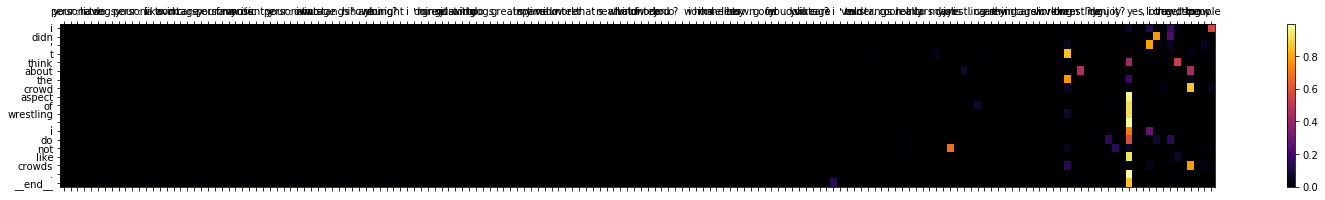

In [20]:
# Set up figure with colorbar
fig = plt.figure(figsize=(150,3))
ax1 = fig.add_subplot(151)
cax1 = ax1.matshow(attention_list[0][:target_lens[0],:input_lens[0]], cmap='inferno', aspect='auto')
fig.colorbar(cax1)

# Set up axes
ax1.set_xticklabels(['']+ x_tokens_list[0], rotation=0)
ax1.set_yticklabels([''] + y_tokens_list[0],rotation=0)

# Show label at every tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))

print("Input:",chat_dict.v2t(text_vecs[BATCH_IDS[0]].tolist()[:input_lens[0]]))
print("\n")
print("Target:",chat_dict.v2t(target_vecs[BATCH_IDS[0]].tolist()[:target_lens[0]]))
plt.show()

In [21]:
len(y_tokens_list[0])

19

In [0]:
# this is some example attention map here, 
# *make sure you add text tokens on the axes to make it readable!*

![Imgur](https://i.imgur.com/xodciCU.png)

## 1.2 Encoder Transformer

In [23]:
!pip install transformers

     |████████████████████████████████| 317kB 8.8MB/s 
     |████████████████████████████████| 1.0MB 74.4MB/s 
     |████████████████████████████████| 645kB 76.5MB/s 
     |████████████████████████████████| 860kB 68.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=f90d107816790915c1cb6cc84d3088b337a2c990a3f8b98a302f51dac4a8d284
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [0]:
import torch.nn as nn
import torch.optim as optim

In [25]:
len(chat_dict)

18760

In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderTransformer(nn.Module):
    def __init__(self,vocab_size,max_len,shared_lt,dropout,dim=256, num_layers=2, nhead=4,pad_idx=0):
      # you need to add more things here
      super().__init__()
      self.token_embed = shared_lt
      #self.token_embed = nn.Embedding(vocab_size, dim)
      self.position_embed = nn.Embedding(max_len, dim)
      encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead)
      self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
      self.pad_idx = pad_idx
      self.dropout = nn.Dropout(p=dropout)
      

    def forward(self, text_vec):
      pos = torch.arange(text_vec.size(1), device=text_vec.device).repeat(1,text_vec.size(0)).view(-1,text_vec.size(1))#.unsqueeze(1)
      #print(self.token_embed(text_vec))
      #print(self.position_embed(pos))
      output = torch.add(self.token_embed(text_vec),self.position_embed(pos))
      output = self.dropout(output)
      #print(output)
      #print(text_vec.shape)
      #print(output.shape)
      attention_mask = text_vec.eq(self.pad_idx)
      
      x = self.transformer(output.transpose(0,1),src_key_padding_mask=attention_mask)
      #print(output.shape)
      x.transpose_(0,1)
      #print(x.shape)
      hidden = torch.mean(x,dim=1,keepdim=True).transpose(0,1)
      return x, hidden , attention_mask


    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderTransformer(
                                    vocab_size=self.opts['vocab_size'],
                                    max_len = 10000,shared_lt = self.decoder.embedding,dropout=self.opts["dropout"]
                                    #embed_size=self.opts['embedding_size'],
                                    #hidden_size=self.opts['hidden_size'],
                                    #num_layers=self.opts['num_layers_enc'],
                                    #dropout=self.opts['dropout'],
                                    #shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
opts = {'dropout': 0.3,
 'embedding_size': 256,
 'encoder_shared_lt': True,
 'hidden_size': 256,
 'num_layers_dec': 1,
 'num_layers_enc': 2,
 'vocab_size': 18760}

In [0]:
model = seq2seq(opts)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 1e-3, amsgrad=True)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [30]:
current_device = "cuda"
model.to(current_device)

seq2seq(
  (decoder): DecoderRNN(
    (dropout): Dropout(p=0.3, inplace=False)
    (embedding): Embedding(18760, 256, padding_idx=0)
    (gru): GRU(256, 256, batch_first=True)
    (attention): AttentionLayer(
      (linear_out): Linear(in_features=512, out_features=256, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (out): Linear(in_features=256, out_features=18760, bias=True)
  )
  (encoder): EncoderTransformer(
    (token_embed): Embedding(18760, 256, padding_idx=0)
    (position_embed): Embedding(10000, 256)
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1

In [31]:
plot_cache = []

best_val_loss = 100

for epoch in range(30):
    
    model.train()
    sum_loss = 0
    sum_tokens = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs)
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        #print(loss.item())
        sum_loss += loss.item()
        #print(num_tokens)
        num_tokens = target_vecs.ne(0).long().sum().item()
        loss /= num_tokens
        
        sum_tokens += num_tokens
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            avg_train_loss = sum_loss/sum_tokens
            print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))
    #break        
    val_loss = 0
    val_tokens = 0
    for i, batch in enumerate(valid_loader):
        model.eval()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')
        
        encoded = model.encoder(text_vecs)
        
        decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        
        val_tokens += num_tokens
        val_loss += loss.item()
        
    avg_val_loss = val_loss/val_tokens
    #scheduler.step(avg_val_loss)
        
    print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))
    
    plot_cache.append( (avg_train_loss, avg_val_loss) )
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        
        torch.save({
        'state_dict': model.state_dict(),
        'opts': opts,
        'plot_cache': plot_cache,
            }, f'./transformer_model_best_{epoch}.pt')

iter 0 train loss = 9.858762548948096
iter 100 train loss = 5.795684763699603
iter 200 train loss = 5.265336603155197
iter 300 train loss = 4.991830030763849
iter 400 train loss = 4.820552728722089
iter 500 train loss = 4.7003766243487055
iter 600 train loss = 4.608378938021887
iter 700 train loss = 4.538711303562329
iter 800 train loss = 4.478030348250525
iter 900 train loss = 4.427710162997196
iter 1000 train loss = 4.3867693475210014
iter 1100 train loss = 4.352782712638307
iter 1200 train loss = 4.3205883344404326
iter 1300 train loss = 4.290433093612011
iter 1400 train loss = 4.264880636695797
iter 1500 train loss = 4.242483382846102
iter 1600 train loss = 4.220223540856455
iter 1700 train loss = 4.2009459229970085
iter 1800 train loss = 4.182403051139307
iter 1900 train loss = 4.166725363187934
iter 2000 train loss = 4.1518319460409225
Epoch 0 valid loss = 3.8969235118970764
iter 0 train loss = 3.6174658145203145
iter 100 train loss = 3.7344643835883122
iter 200 train loss = 3.73

## You present here:

In [37]:
# check pdf to see what you expected to present
model_pt = torch.load("transformer_model_best_5.pt")
plot_cache = model_pt['plot_cache']
model = seq2seq(model_pt['opts'])
model.load_state_dict(model_pt["state_dict"])

<All keys matched successfully>

In [44]:
!md5sum "transformer_model_best_5.pt"

9a6346efc2ac4cb967f1c034dd30ab26  transformer_model_best_5.pt


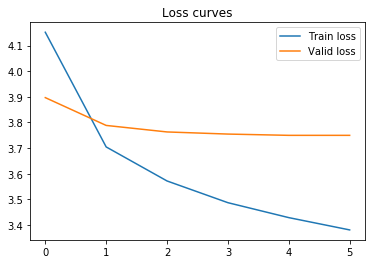

In [45]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

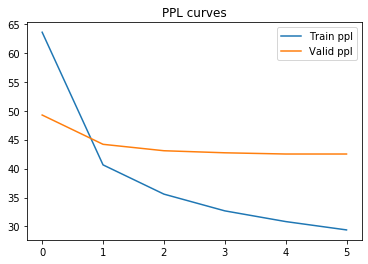

In [46]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [47]:
print("Val PPL:",2**(plot_cache[-1][1]/numpy.log(2)))

Val PPL: 42.51510228453153
